In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotnine as p9


#  1 样本数据检查及前处理
## 1.1 样本数据检查

In [33]:
# 0 整理样本数据与样本信息
rawdata = pd.read_csv("../data/WOSP22061-result/2-Input/Protein_Matrix.csv", header=0, index_col=0)
rawinfo = pd.read_csv("../data/WOSP22061-result/2-Input/wosp22061single_sample_info.csv", header=0, index_col=0)

rawinfo = rawinfo.loc[rawdata.columns, ["Sample.Name", "Label", "Batch", "Source"]]
rawinfo.columns = ["ID", "Region", "Batch", "Hemi"]
rawinfo["Batch"] = "Batch" + rawinfo["Batch"].astype("str")
rawinfo["Region"] = [ str(i)[:-1] for i in rawinfo["Region"] ]
rawinfo["Group"] = [ i[0]+"-"+j for i, j in zip(rawinfo["Hemi"], rawinfo["Region"])]

rawdata.columns = rawinfo.loc[rawdata.columns, "ID"]
rawinfo.set_index("ID", inplace=True)

In [3]:
# 1 check NA value distribution
na_idx = rawdata.isna()

protein_NA_ratio = pd.DataFrame(na_idx.sum(axis=1) / rawdata.shape[1], columns=["Ratio"])
protein_NA_ratio.reset_index(inplace=True)

sample_NA_ratio = pd.DataFrame(na_idx.sum(axis=0) / rawdata.shape[0], columns=["Ratio"])
tmp = []
for i in ["Region", "Batch"]:
    b1 = sample_NA_ratio.copy()
    if i == "Region":
        b1["Group"] = [ str(j)[0] +"-"+k for j, k in zip(rawinfo.loc[b1.index, "Hemi"], rawinfo.loc[b1.index, i]) ]
        b1.sort_values(by=["Group", "ID"], inplace=True)
        b1["Type"] = "Hemi-Region"
        b1["Name"] = rawinfo.loc[b1.index, i] + "-" + b1.index
    else:
        b1["Group"] = rawinfo.loc[b1.index, i]
        b1.sort_values(by=["Group", "ID"], inplace=True)
        b1["Type"] = i
        b1["Name"] = b1["Group"] + "-" + b1.index
    tmp.append(b1.copy())
sample_NA_ratio = pd.concat(tmp, axis=0)

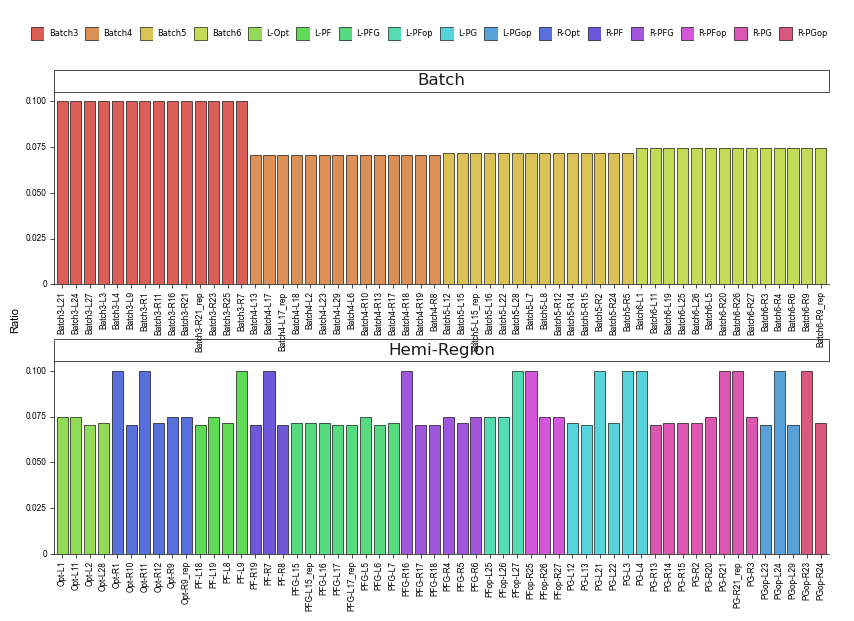

<ggplot: (8757612339604)>

In [4]:
barplot = ( p9.ggplot(p9.aes(x="Name", y="Ratio", fill="Group"), sample_NA_ratio) 
  + p9.geom_bar(stat="identity", color="black", size=0.25, width=0.8)
  + p9.theme_classic()
  + p9.scale_y_continuous(expand = [0, 0, 0.05, 0])
  + p9.theme(figure_size=(10, 6),
              axis_text = p9.element_text(color="black", size=6, family="Arial"),
              axis_text_x = p9.element_text(angle=90),
              axis_title=p9.element_text(color="black", size=8, family="Arial"),
              axis_title_x = p9.element_blank(),
              axis_line = p9.element_line(size=0.5),
              axis_ticks = p9.element_line(color="black", size=0.5),
              axis_ticks_minor_y=p9.element_blank(),
              
              legend_title=p9.element_blank(),
              legend_text=p9.element_text(color="black", size=6),
              legend_key_size=10,
              legend_background=p9.element_blank(),
              legend_direction="horizontal",
              legend_position="top",
              strip_background=p9.element_rect(size=0.5),
              strip_text=p9.element_text(size=12),
              subplots_adjust={"hspace":0.4})
  + p9.guides(fill=p9.guide_legend(nrow=1, byrow=True))
  + p9.facet_wrap("~Type", nrow=3, ncol=1, scales="free_x")
)
p9.ggsave(barplot, "../res/0.preprocessing/0.sample_NA_ratio.pdf", width=10, height=6, verbose=False )
barplot

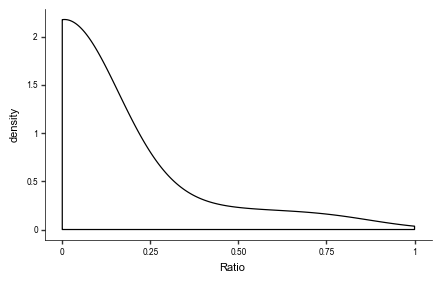

<ggplot: (8757611894998)>

In [5]:
density_plot = ( p9.ggplot(p9.aes(x="Ratio"), protein_NA_ratio) 
  + p9.geom_density()
  + p9.theme_classic()
  + p9.xlim(0, 1)
  + p9.theme(figure_size=(5, 3),
              axis_text = p9.element_text(color="black", size=6, family="Arial"),
              axis_title=p9.element_text(color="black", size=8, family="Arial"),
              axis_line = p9.element_line(size=0.5),)
)
p9.ggsave(barplot, "../res/0.preprocessing/0.protein_NA_ratio_density.pdf", width=5, height=3, verbose=False )
density_plot

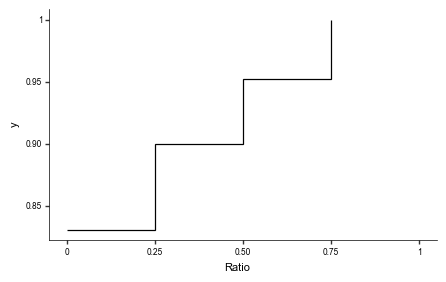

<ggplot: (8757611681753)>

In [6]:
density_plot = ( p9.ggplot(p9.aes(x="Ratio"), protein_NA_ratio) 
  + p9.stat_ecdf()
  + p9.theme_classic()
  + p9.xlim(0, 1)
  + p9.theme(figure_size=(5, 3),
              axis_text = p9.element_text(color="black", size=6, family="Arial"),
              axis_title=p9.element_text(color="black", size=8, family="Arial"),
              axis_line = p9.element_line(size=0.5),)
)
p9.ggsave(barplot, "../res/0.preprocessing/0.protein_NA_ratio_cdf.pdf", width=5, height=3, verbose=False )
density_plot

In [7]:
protein_NA_ratio.shape, (protein_NA_ratio["Ratio"] >= 0.5).sum()

((6419, 2), 642)

## 1.2 样本前处理

In [21]:
# 1. 去除缺失比例>=50%的蛋白
na_thr = 0.5
prot_idx = rawdata.isna().sum(axis=1)/rawdata.shape[1] < na_thr
cleandata_filt_na_prot = rawdata.loc[prot_idx, :]

In [23]:
# 2. Median normalization
cleandata_median_norm = cleandata_filt_na_prot / cleandata_filt_na_prot.median(axis=0, skipna=True)

In [51]:
# 3. check CV: 都符合样本CV取值的范围要求
group_mean = cleandata_median_norm.T.groupby(by=rawinfo["Group"]).mean()
group_std = cleandata_median_norm.T.groupby(by=rawinfo["Group"]).std(ddof=0)
group_cv = (group_std / group_mean).T.melt(value_name="CV", var_name="Group")

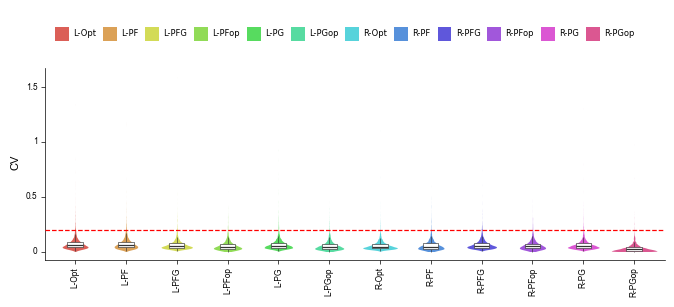

<ggplot: (8757609901144)>

In [80]:
violin_plot = (p9.ggplot(p9.aes(x="Group", y="CV", ), group_cv)
  + p9.geom_violin(p9.aes(fill="Group"), color=None)
  + p9.geom_boxplot( width=0.3, size=0.25, outlier_shape=None, outlier_alpha=0)
  + p9.geom_hline(yintercept=0.2, color="red", linetype="dashed", size=0.5)
  + p9.theme_classic()
  + p9.theme(figure_size=(8, 2.5),
              axis_text = p9.element_text(color="black", size=6, family="Arial"),
              axis_text_x = p9.element_text(angle=90),
              axis_title=p9.element_text(color="black", size=8, family="Arial"),
              axis_title_x = p9.element_blank(),
              axis_line = p9.element_line(size=0.5),
              axis_ticks = p9.element_line(color="black", size=0.5),
              axis_ticks_minor_y=p9.element_blank(),
              
              legend_title=p9.element_blank(),
              legend_text=p9.element_text(color="black", size=6),
              legend_key_size=10,
              legend_background=p9.element_blank(),
              legend_direction="horizontal",
              legend_position="top",
              strip_background=p9.element_rect(size=0.5),
              strip_text=p9.element_text(size=12),
              subplots_adjust={"hspace":0.4})
  + p9.guides(fill=p9.guide_legend(nrow=1, byrow=True))
)
p9.ggsave(barplot, "../res/0.preprocessing/0.group_cv.pdf", width=8, height=2.5, verbose=False )
violin_plot

In [66]:
group_cv_pass_ratio = ((group_std / group_mean).T < 0.2).sum(axis=0)/cleandata_median_norm.shape[0]
group_cv_median = (group_std / group_mean).T.median(axis=0, skipna=True)
pd.concat([group_cv_pass_ratio, group_cv_median], axis=1)

,0,1
Group,,
L-Opt,0.973516,0.055948
L-PF,0.971612,0.057363
L-PFG,0.981651,0.050122
L-PFop,0.986498,0.041703
L-PG,0.979228,0.053021
L-PGop,0.987883,0.040806
R-Opt,0.988748,0.044204
R-PF,0.982690,0.044737
R-PFG,0.982863,0.052276


In [83]:
## 4. log transformation
cleandata_log_trans =  np.log2(cleandata_median_norm)

In [89]:
violin_dat = cleandata_log_trans.melt(var_name="ID", value_name="Expr")
violin_dat = violin_dat.loc[~violin_dat["Expr"].isna(), :]

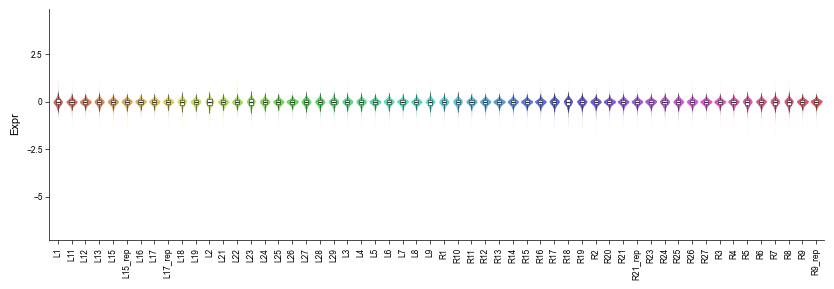

<ggplot: (8757610496883)>

In [91]:
violin_plot = (p9.ggplot(p9.aes(x="ID", y="Expr", ), violin_dat)
  + p9.geom_violin(p9.aes(fill="ID"), color=None)
  + p9.geom_boxplot( width=0.3, size=0.25, outlier_shape=None, outlier_alpha=0)
  + p9.theme_classic()
  + p9.theme(figure_size=(10, 3),
              axis_text = p9.element_text(color="black", size=6, family="Arial"),
              axis_text_x = p9.element_text(angle=90),
              axis_title=p9.element_text(color="black", size=8, family="Arial"),
              axis_title_x = p9.element_blank(),
              axis_line = p9.element_line(size=0.5),
              axis_ticks = p9.element_line(color="black", size=0.5),
              axis_ticks_minor_y=p9.element_blank(),
              
              legend_title=p9.element_blank(),
              legend_text=p9.element_text(color="black", size=6),
              legend_key_size=10,
              legend_background=p9.element_blank(),
              legend_direction="horizontal",
              legend_position="top",
              strip_background=p9.element_rect(size=0.5),
              strip_text=p9.element_text(size=12),
              subplots_adjust={"hspace":0.4})
  + p9.guides(fill=False)
)
#p9.ggsave(barplot, "../res/0.preprocessing/0.group_cv.pdf", width=8, height=2.5, verbose=False )
violin_plot

In [195]:
## 5. evaluate NA imputation method and impute NA
import utils



In [197]:
tmp = utils.seq_KNN(cleandata_log_trans, k=10)


In [199]:
import networkx